# Validation case study: Matching NMR spectra to composition of the molecule

Following data extraction, it is crucial to implement automated checks to ensure the validity of the extracted data. One effective validation method involves matching the extracted NMR spectra to the corresponding analyzed molecule. This process compares the number of protons and peaks in the molecule's theoretical NMR spectra with those in the extracted NMR spectra. This approach is similar to that employed by {cite:t}`Patiny_2023`.

In this notebook, we demonstrate an example of how to perform this automated validation check. By implementing such checks, researchers can significantly enhance the reliability and accuracy of their extracted spectroscopic data, thereby improving the overall quality of their analyses. 

### Data extraction

The first step in our process involves extracting the NMR spectra and the analyzed molecule using a Large Language Model (LLM). To accomplish this, we developed a basic prompt that includes the desired information and the content of the article. As a result, we obtain the names of the molecules and the NMR spectra of all included molecules in a structured JSON format.

We will start using data from an article by {cite:t}`Gevorgyan2021` that we downloaded manually.

We first define some logic to extract the text from the PDF file and to call the LLM.

In [16]:
import matextract  # noqa: F401
from litellm import completion
import json
from doctr.io import DocumentFile
from doctr.models import ocr_predictor


def convert_pdf_with_doctr(pdf_path, det_arch="db_resnet50", reco_arch="crnn_vgg16_bn"):
    model = ocr_predictor(det_arch=det_arch, reco_arch=reco_arch, pretrained=True)
    model = ocr_predictor(pretrained=True)
    # PDF
    doc = DocumentFile.from_pdf(pdf_path)
    # Analyze
    result = model(doc)

    return result.render()


# Add the content of the XML file to the prompt
def format_prompt(template: str, text: str) -> str:
    return template.format(data=text)


# Define the function to call the LiteLLM API
def call_litellm(
    prompt: str, model: str = "gpt-4o", temperature: float = 0.0, **kwargs
) -> tuple:
    """Call LiteLLM model

    Args:
        prompt (str): Prompt to send to model
        model (str, optional): Name of the API. Defaults to "gpt-4o".
        temperature (float, optional): Inference temperature. Defaults to 0.
        kwargs (dict, optional): Additional arguments to pass to the API.

    Returns:
        tuple: message content and token usage (message_content, input_tokens, output_tokens)
    """
    messages = [
        {
            "role": "system",
            "content": (
                "You are a scientific assistant, extracting NMR spectra and the analyzed molecule "
                "out of XML documents in valid JSON format. Extract just data which you are 100% confident about the "
                "accuracy. Keep the entries short without details. Be careful with numbers."
            ),
        },
        {"role": "user", "content": prompt},
    ]

    response = completion(
        model=model,
        messages=messages,
        temperature=temperature,
        response_format={"type": "json_object"},
        **kwargs,
    )

    # Extract and return the message content and token usage
    message_content = response["choices"][0]["message"]["content"]
    input_tokens = response["usage"]["prompt_tokens"]
    output_tokens = response["usage"]["completion_tokens"]
    return message_content, input_tokens, output_tokens

In [17]:
text = convert_pdf_with_doctr("./gevorgyan.pdf")

In [18]:
print(text)

ORGANOMETALLICS

AGO
Article

pubxasoOgpmomelics

Improved Buchwald-Hartwig Amination by the Use of Lipids and

Lipid Impurities

Ashot Gevorgyan, * Kathrin H. Hopmann, and Annette Bayer

Cite This: Organometalics 2022, 41, 1777-1785

Read Online

ACCESSI

Lil Metrics & More

Article Recommendations

Supporting Information
Catayst,
Solvent,
Additive

ABSTRACT: The development of green Buchwald-Hartwig aminations has long been Buchwald-Hartwig/ Aminationi in' Vegetable Oilsa and RelatedLipids

considered challenging, due to thel high sensitivity oft the reaction to the environment. Here
we show that food-grade and waste vegetable oils, triglycerides originating from animals,
and natural waxes can serve as excellent green solvents for Buchwald-Hartwig amination.
We further demonstrate that amphiphiles and trace ingredients present in triglycerides as
additives have a decisive effect on the yields of Buchwald-Hartwig aminations.

SMOR

INTRODUCTION
bonds
C-N

containing different function

In [19]:
# Define the prompt template
prompt_template = """Extract all 1H-NMR-spectra and the related analyzed molecule out of this XML file: {data}. 
Extract the complete 1-H-NMR-spectra as text. Extract the full IUPAC name of the molecules without abbreviations and details.
Extract the data in the following JSON format:"
    {{"molecules": [
        {{
            "molecule":
            "nmr_spectra":
        }},
        {{
            "molecule":
            "nmr_spectra":
        }}
        ]
    }}"""

# Add the XML data to the promp
prompt = format_prompt(prompt_template, text)

Now we can perform the actual call to the LLM.

In [20]:
# Call the LiteLLM API and print the output and token usage
output, input_tokens, output_tokens = call_litellm(prompt=prompt)
output = json.loads(output)
print("Output: ", output)
print("Input tokens used:", input_tokens, "Output tokens used:", output_tokens)

with open("NMR_data.json", "w", encoding="utf-8") as json_file:
    json.dump(output, json_file, indent=4)

Output:  {'molecules': [{'molecule': '4-methoxy-3,5-bis(trifluoromethyl)aniline', 'nmr_spectra': '3.66 (s, 3H, OMe), 5.66 (br s, 1H, NH), 6.75-6.79 (m, 2H, Ar), 6.93-6.97 (m, 2H, Ar), 7.00 (s, 2H, Ar), 7.07 (s, 1H, Ar)'}, {'molecule': '4-methyl-3,5-bis(trifluoromethyl)aniline', 'nmr_spectra': '2.40 (s, 3H, Me), 5.89 (br s, 1H, NH), 7.09 (d, J = 8.1 Hz, 2H, Ar), 7.23 (d, J = 8.0 Hz, 2H, Ar), 7.32 (s, 3H, Ar)'}, {'molecule': '4-methoxy-3,5-bis(trifluoromethyl)aniline', 'nmr_spectra': '6.11 (br s, 1H, NH), 7.33-7.36 (m, 3H, Ar), 7.44 (s, 3H, Ar), 7.49 (d, J = 7.8 Hz, 1H, Ar)'}, {'molecule': '4-methyl-N-phenyl-3,5-bis(trifluoromethyl)aniline', 'nmr_spectra': '3.37 (s, 3H, NMe), 7.14 (s, 2H, Ar), 7.18-7.20 (m, 2H, Ar), 7.22-7.26 (m, 2H, Ar), 7.40-7.46 (m, 2H, Ar)'}, {'molecule': 'N-benzyl-3,5-bis(trifluoromethyl)aniline', 'nmr_spectra': '4.38-4.46 (m, 3H, CH2/NH), 6.99 (d, J = 8.1 Hz, 2H, Ar), 7.19 (s, 1H, Ar), 7.32-7.42 (m, 5H, Ar)'}, {'molecule': '3-(3,5-bis(trifluoromethyl)phenyl)-1H-ind

### Validity check with NMR spectra and SMILES

Next, we count and compare the hydrogen atoms in the extracted NMR spectra and molecule. We also calculate and compare the number of peaks in the NMR spectra and diastereotopic protons in the molecule. If the numbers do not match, we can assume an error in the extraction.

For doing so, we will need to define a few helper functions. The first one will compute the number of symmetry equivalent hydrogen atoms.

In [21]:
import rdkit
from rdkit import Chem
import numpy as np

In [22]:
def get_number_of_topologically_distinct_atoms(molecule, atomic_number: int = 1):
    """Return the number of unique `element` environments based on environmental topology.

    Args:
        molecule (rdkit.Chem.rdchem.Mol): Molecular instance.
        atomic_number (int, optional): Atomic number. Defaults to 1.

    Returns:
        int: Number of unique environments.
    """
    if atomic_number == 1:
        # add hydrogen
        mol = Chem.AddHs(molecule)
    else:
        mol = molecule

    # Get unique canonical atom rankings
    atom_ranks = list(rdkit.Chem.rdmolfiles.CanonicalRankAtoms(mol, breakTies=False))

    # Select the unique element environments
    atom_ranks = np.array(atom_ranks)

    # Atom indices
    atom_indices = [
        atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == atomic_number
    ]
    # Count them
    return len(set(atom_ranks[atom_indices]))

If we look at an example, e.g., for benzene `c1ccccc1`, we can see that the number of topologically distinct hydrogen atoms is 1.
In contrast, if we look at ethanol, `CCO`, we can see that the number of topologically distinct hydrogen atoms is 3.

In [23]:
get_number_of_topologically_distinct_atoms(
    Chem.MolFromSmiles("c1ccccc1"), atomic_number=1
)

1

In [24]:
get_number_of_topologically_distinct_atoms(Chem.MolFromSmiles("CCO"), atomic_number=1)

3

In addition, we need to find the number of peaks in NMR spectra. For this we will use a regular expression.

In [25]:
import re


def count_hydrogens_from_nmr(nmr_spectra: str) -> int:
    pattern2 = r"\b(\d+)H\b"
    matches = re.findall(pattern2, nmr_spectra)
    return sum(int(match) for match in matches)

Using those two functions, we can calculate how often the extraction matches our expectation.

In [26]:
import json
import pandas as pd
import matextract.utils as utils

results = []
pattern = re.compile(r"\d+\.\d+\s*\([^)]*\)")

# Load JSON NMR data
with open("NMR_data.json", "r") as file:
    data = json.load(file)


# Loop over all molecules in data
for molecule_data in data["molecules"]:
    molecule_name = molecule_data["molecule"]
    nmr_spectra = molecule_data["nmr_spectra"]

    print(f"Processing molecule: {molecule_name}")

    # Calculate number of hydrogen atoms in NMR data
    H_number_nmr = count_hydrogens_from_nmr(nmr_spectra)

    # Count the number of peaks in the NMR spectra
    peaks = pattern.findall(nmr_spectra)
    found_number_of_peaks = len(peaks)

    # Convert molecules into SMILES
    mol_smiles = utils.name_to_smiles(molecule_name)
    if mol_smiles:
        # Convert SMILES into RDKit objects
        mol = Chem.MolFromSmiles(mol_smiles)
        if mol:
            expected_number_of_peaks = get_number_of_topologically_distinct_atoms(mol)

        else:
            print(
                f"Failed to create RDKit molecule object from SMILES for {molecule_name}"
            )
            H_number = None
            mol = None
    else:
        print(f"Failed to convert {molecule_name} to SMILES")
        H_number = None
        mol = None

    results.append(
        {
            "peaks": peaks,
            "molecule": molecule_name,
            "H_number_nmr": H_number_nmr,
            "rdkit_mol": mol,
            "mol_smiles": mol_smiles,
            "found_number_of_peaks": found_number_of_peaks,
            "expected_number_of_peaks": expected_number_of_peaks,
        }
    )

Processing molecule: 4-methoxy-3,5-bis(trifluoromethyl)aniline
Processing molecule: 4-methyl-3,5-bis(trifluoromethyl)aniline
Processing molecule: 4-methoxy-3,5-bis(trifluoromethyl)aniline
Processing molecule: 4-methyl-N-phenyl-3,5-bis(trifluoromethyl)aniline
Processing molecule: N-benzyl-3,5-bis(trifluoromethyl)aniline
Processing molecule: 3-(3,5-bis(trifluoromethyl)phenyl)-1H-indole
Processing molecule: 3-(3,5-bis(trifluoromethyl)phenyl)-1H-pyrrole
Processing molecule: 4-methyl-3,5-bis(trifluoromethyl)phenol
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline
Processing molecule: 4-methyl-N-phenylaniline


In [27]:
df = pd.DataFrame(results)

We can now also use some utility form `rdkit` to visualize the molecules in the dataframe.

In [28]:
df.dropna(subset=["rdkit_mol"], inplace=True)

In [29]:
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(df, molCol="rdkit_mol", smilesCol="mol_smiles")

,peaks,molecule,H_number_nmr,rdkit_mol,mol_smiles,found_number_of_peaks,expected_number_of_peaks
0,"[3.66 (s, 3H, OMe), 5.66 (br s, 1H, NH), 6.79 ...","4-methoxy-3,5-bis(trifluoromethyl)aniline",11,,COc1c(C(F)(F)F)cc(N)cc1C(F)(F)F,6,3
1,"[2.40 (s, 3H, Me), 5.89 (br s, 1H, NH), 7.09 (...","4-methyl-3,5-bis(trifluoromethyl)aniline",11,,Cc1c(C(F)(F)F)cc(N)cc1C(F)(F)F,5,3
2,"[6.11 (br s, 1H, NH), 7.36 (m, 3H, Ar), 7.44 (...","4-methoxy-3,5-bis(trifluoromethyl)aniline",8,,COc1c(C(F)(F)F)cc(N)cc1C(F)(F)F,4,3
3,"[3.37 (s, 3H, NMe), 7.14 (s, 2H, Ar), 7.20 (m,...","4-methyl-N-phenyl-3,5-bis(trifluoromethyl)aniline",11,,Cc1c(C(F)(F)F)cc(Nc2ccccc2)cc1C(F)(F)F,5,6
4,"[4.46 (m, 3H, CH2/NH), 6.99 (d, J = 8.1 Hz, 2H...","N-benzyl-3,5-bis(trifluoromethyl)aniline",11,,FC(F)(F)c1cc(NCc2ccccc2)cc(C(F)(F)F)c1,4,7
5,"[6.80 (d, J = 3.4 Hz, 1H, Ar), 7.29 (m, 1H, Ar...","3-(3,5-bis(trifluoromethyl)phenyl)-1H-indole",6,,FC(F)(F)c1cc(-c2c[nH]c3ccccc23)cc(C(F)(F)F)c1,5,8
6,"[6.45 (m, 2H, pyrrole), 7.16 (m, 2H, pyrrole),...","3-(3,5-bis(trifluoromethyl)phenyl)-1H-pyrrole",7,,FC(F)(F)c1cc(-c2cc[nH]c2)cc(C(F)(F)F)c1,4,6
7,"[2.40 (s, 3H, Me), 7.00 (m, 2H, Ar), 7.26 (m, ...","4-methyl-3,5-bis(trifluoromethyl)phenol",9,,Cc1c(C(F)(F)F)cc(O)cc1C(F)(F)F,4,3
8,"[2.43 (s, 6H, 2xMe), 5.54 (br s, 1H, NH), 7.09...",4-methyl-N-phenylaniline,15,,Cc1ccc(Nc2ccccc2)cc1,4,7
9,"[2.45 (s, 3H, Me), 5.66 (br s, 1H, NH), 7.04 (...",4-methyl-N-phenylaniline,11,,Cc1ccc(Nc2ccccc2)cc1,5,7

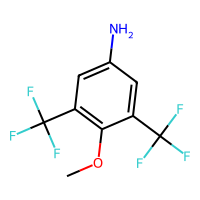
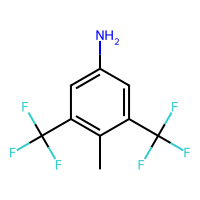
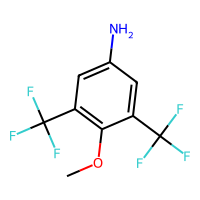
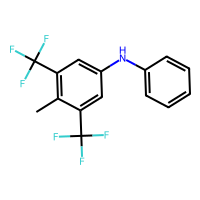
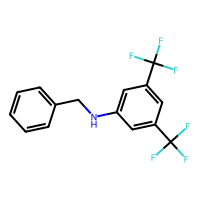
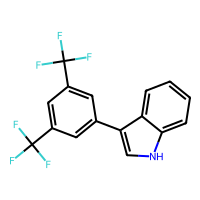
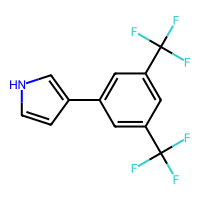
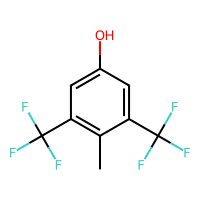
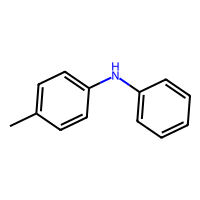
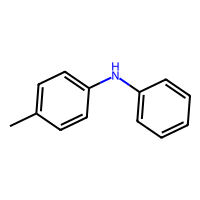
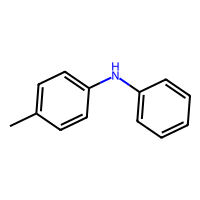
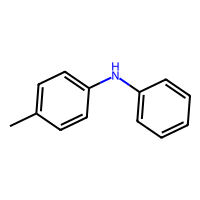
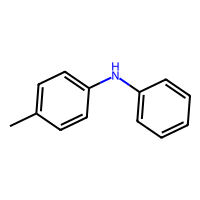
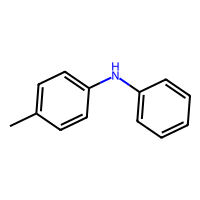
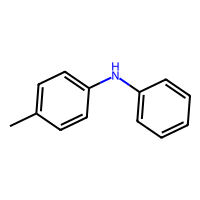

In [30]:
df

We see that in only one case the number of expected peaks matches the number of observed peak. Interestingly, the number of peaks vary for the different samples that the model extract for the 4-methyl-N-phenylaniline, and one of them is the only compound for which both numbers, expected and extracted match.

Since hydrogen atoms with a very similar environment could appear in an NMR spectra as one overlapped peak, the calculated number of peaks could deviate from the observed one. To meet this challenge, one could instead of only considering the symmetry equivalent environments, perform a basic simulation of the NMR spectrum. 

## Bibliography

```{bibliography}
:filter: docname in docnames
```